In [1]:
# ==============================================================================
# SE4050 - Deep Learning Assignment
# Component: EfficientNetB0 Model for Tea Leaf Disease Detection
# ==============================================================================

# ------------------------------------------------------------------------------
# Step 1: Setup and Import Libraries
# ------------------------------------------------------------------------------
!pip install kagglehub -q
print("Step 1: Setting up the environment and importing libraries...")

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import kagglehub
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries imported successfully.")

Step 1: Setting up the environment and importing libraries...
Libraries imported successfully.


In [2]:
# ------------------------------------------------------------------------------
# Step 2: Download Dataset using KaggleHub
# ------------------------------------------------------------------------------
print("Step 2: Downloading dataset using KaggleHub...")

# Note: This requires your Kaggle API token ('kaggle.json').
# In Colab, upload your 'kaggle.json' file to the session storage.
# The kagglehub library will automatically find and use it.
try:
    # Download the latest version of the dataset
    dataset_path = kagglehub.dataset_download("uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka")
    print(f"Dataset downloaded to: {dataset_path}")

    # The actual image folders are inside a subdirectory. We need to define that path.
    # Based on the dataset structure, the images are in 'tea_leaf_diseases_sri_lanka'.
    data_dir = dataset_path
    print(f"Image data directory set to: {data_dir}")

except Exception as e:
    print(f"An error occurred during download: {e}")
    print("Please ensure your 'kaggle.json' API token is uploaded to the Colab session.")
    # You can exit or handle the error as needed
    data_dir = None

# Proceed only if the data directory was set successfully
if data_dir and os.path.exists(data_dir):
    print("Dataset is ready.")
else:
    print("Could not find the dataset directory. Halting execution.")
    # Stop the script if the dataset is not available
    exit()

Step 2: Downloading dataset using KaggleHub...
Using Colab cache for faster access to the 'common-diseases-of-tea-leaves-in-sri-lanka' dataset.
Dataset downloaded to: /kaggle/input/common-diseases-of-tea-leaves-in-sri-lanka
Image data directory set to: /kaggle/input/common-diseases-of-tea-leaves-in-sri-lanka
Dataset is ready.


In [3]:
# ------------------------------------------------------------------------------
# Step 3: Define Constants and Image Data Generators
# ------------------------------------------------------------------------------
print("Step 3: Defining constants and setting up data generators...")

IMG_WIDTH, IMG_HEIGHT = 224, 224  # EfficientNetB0 works well with 224x224 images
BATCH_SIZE = 32
NUM_EPOCHS = 25

# Create an ImageDataGenerator for the training set with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2        # Use 20% of the data for validation
)

# Create a generator for the validation set (only normalization)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load data from the directory using the generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Get class information
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Found {train_generator.samples} images for training.")
print(f"Found {validation_generator.samples} images for validation.")
print(f"Classes found: {class_names}")

Step 3: Defining constants and setting up data generators...
Found 960 images belonging to 8 classes.
Found 236 images belonging to 8 classes.
Found 960 images for training.
Found 236 images for validation.
Classes found: ['Algal Leaf', 'Anthracnose', 'Bird Eye Spot', 'Brown Blight', 'Gray Light', 'Healthy', 'Red Leaf Spot', 'White Spot']


In [4]:
# ------------------------------------------------------------------------------
# Step 4: Build the Transfer Learning Model (EfficientNetB0)
# ------------------------------------------------------------------------------
print("Step 4: Building the EfficientNetB0 model with transfer learning...")

# Load the pre-trained EfficientNetB0 model without its final classification layer
base_model_efficientnet = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
)

# Freeze the layers of the pre-trained base model
for layer in base_model_efficientnet.layers:
    layer.trainable = False

# Add our custom classification head on top
x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)  # Reduces the feature map dimensions
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model by combining the base and the custom head
model_efficientnet = Model(inputs=base_model_efficientnet.input, outputs=predictions)

Step 4: Building the EfficientNetB0 model with transfer learning...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# ------------------------------------------------------------------------------
# Step 5: Compile the Model
# ------------------------------------------------------------------------------
print("Step 5: Compiling the model...")

model_efficientnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model's architecture
model_efficientnet.summary()

Step 5: Compiling the model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,369,515 (20.48 MB)

 Trainable params: 1,319,944 (5.04 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
# ------------------------------------------------------------------------------
# Step 6: Train the Model
# ------------------------------------------------------------------------------
print(f"Step 6: Starting model training for {NUM_EPOCHS} epochs...")

history_efficientnet = model_efficientnet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    verbose=1
)

print("Training finished successfully.")

Step 6: Starting model training for 25 epochs...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - accuracy: 0.1456 - loss: 2.2237 - val_accuracy: 0.1964 - val_loss: 2.1115
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.1369 - loss: 2.1588 - val_accuracy: 0.1161 - val_loss: 2.0745
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step - accuracy: 0.1707 - loss: 2.0713 - val_accuracy: 0.1964 - val_loss: 2.0630
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.1794 - loss: 2.0564 - val_accuracy: 0.1964 - val_loss: 2.0590
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step - accuracy: 0.2117 - loss: 2.0536 - val_accuracy: 0.1161 - val_loss: 2.0661
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.2059 - loss: 2.0561 - val_accuracy: 0.1964 - val_loss: 2.0611
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.1496 - loss: 2.0688 - val_accuracy: 0.1964 - val_loss: 2.0606
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.1903 - loss: 2.0564 - val_accuracy: 0.1964 - v

Step 7: Evaluating the model and visualizing performance...


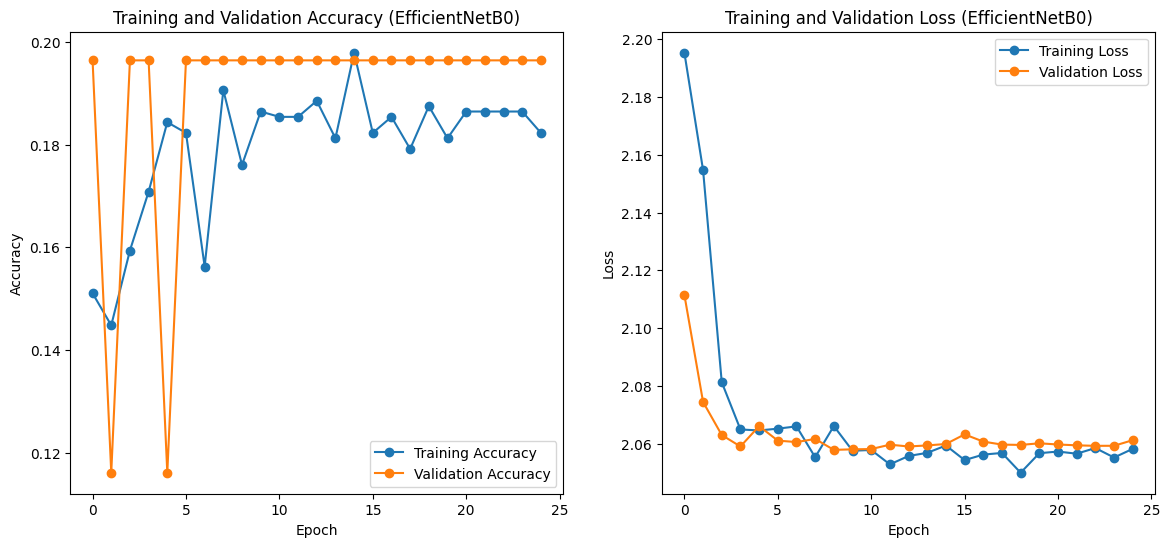

8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step

Classification Report (EfficientNetB0):

               precision    recall  f1-score   support

   Algal Leaf       0.00      0.00      0.00        30
  Anthracnose       0.00      0.00      0.00        25
Bird Eye Spot       0.00      0.00      0.00        27
 Brown Blight       0.00      0.00      0.00        28
   Gray Light       0.00      0.00      0.00        24
      Healthy       0.00      0.00      0.00        20
Red Leaf Spot       0.19      1.00      0.31        44
   White Spot       0.00      0.00      0.00        38

     accuracy                           0.19       236
    macro avg       0.02      0.12      0.04       236
 weighted avg       0.03      0.19      0.06       236


Confusion Matrix (EfficientNetB0):



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


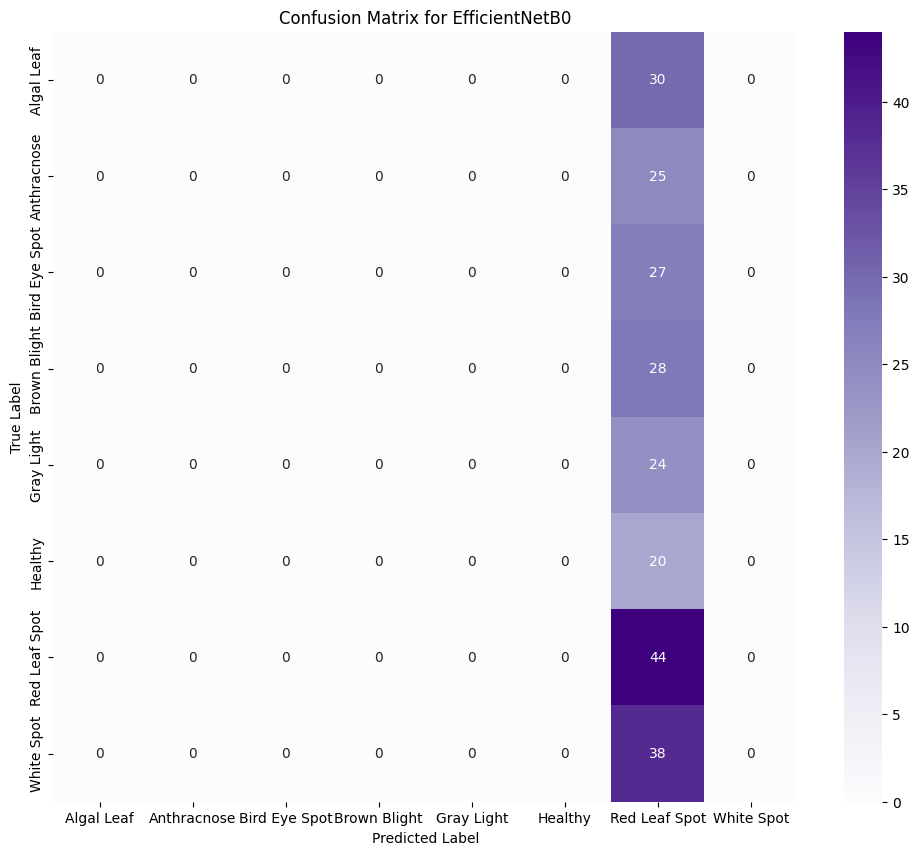

In [7]:
# ------------------------------------------------------------------------------
# Step 7: Evaluate the Model and Visualize Performance
# ------------------------------------------------------------------------------
print("Step 7: Evaluating the model and visualizing performance...")

# Plot training & validation accuracy and loss curves
acc = history_efficientnet.history['accuracy']
val_acc = history_efficientnet.history['val_accuracy']
loss = history_efficientnet.history['loss']
val_loss = history_efficientnet.history['val_loss']
epochs_range = range(len(acc)) # Use length of history lists for x-axis

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (EfficientNetB0)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (EfficientNetB0)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Generate predictions on the validation set
Y_pred = model_efficientnet.predict(validation_generator, (validation_generator.samples // BATCH_SIZE) + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Generate and print the classification report
print("\nClassification Report (EfficientNetB0):\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate and display the confusion matrix
print("\nConfusion Matrix (EfficientNetB0):\n")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for EfficientNetB0')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [8]:
# ------------------------------------------------------------------------------
# Step 8: Save the Trained Model
# ------------------------------------------------------------------------------
print("Step 8: Saving the final trained model...")
model_efficientnet.save('efficientnetB0_tea_leaf_disease_model.h5')
print("Model saved successfully as 'efficientnetB0_tea_leaf_disease_model.h5'")

# ==============================================================================
# End of Script
# ==============================================================================

Step 8: Saving the final trained model...
Model saved successfully as 'efficientnetB0_tea_leaf_disease_model.h5'
